In [1]:
import cv2
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from typing import Tuple, List
from scipy.interpolate import interp1d
from scipy.ndimage import map_coordinates
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

def draw_partial_circle(mask, center, r, angle_start, angle_end, thickness=2):
    """
    Draws an arc (partial circle) on a mask from angle_start to angle_end.
    Angles are in degrees.
    """
    axes = (r, r)
    cv2.ellipse(mask, center, axes, 0, angle_start, angle_end, 255, thickness)

def daugman(gray_img: np.ndarray, center: tuple, start_r: int, end_r: int, step: int = 1,
            angle_start: int = 45, angle_end: int = 135, thickness: int = 2) -> tuple:
    """
    Improved Daugman operator using partial circles to avoid occluded regions.

    Parameters:
        gray_img: Grayscale eye image
        center: (x, y) tuple
        start_r: Start of radius range
        end_r: End of radius range
        step: Radius increment step
        angle_start: Start angle of arc (in degrees)
        angle_end: End angle of arc (in degrees)
        thickness: Thickness of arc

    Returns:
        max_response: maximum intensity gradient
        best_radius: radius corresponding to max_response
    """
    x, y = center
    mask = np.zeros_like(gray_img, dtype=np.uint8)
    radii = list(range(start_r, end_r, step))
    intensities = []

    for r in radii:
        # Draw both top and bottom horizontal arcs (excluding eyelids)
        draw_partial_circle(mask, center, r, 60, 135, thickness)     # top/middle
        draw_partial_circle(mask, center, r, 225, 300, thickness)    # bottom/middle
    
        diff = gray_img & mask
    
        if np.count_nonzero(diff) > 0:
            avg_intensity = np.sum(diff[diff > 0]) / np.count_nonzero(diff)
        else:
            avg_intensity = 0
    
        intensities.append(avg_intensity)
        mask.fill(0)

    # Compute gradient of intensities
    intensities_np = np.array(intensities, dtype=np.float32)
    gradient = intensities_np[:-1] - intensities_np[1:]
    gradient = cv2.GaussianBlur(np.abs(gradient), (1, 5), 0)

    # Find strongest gradient
    idx = np.argmax(gradient)
    return gradient[idx], radii[idx]

def enhance_iris_contrast(gray_img):
    """
    Enhance contrast between iris and sclera in a grayscale image.
    
    Parameters:
    - gray_img: Grayscale image (NumPy array)
    
    Returns:
    - enhanced_gray: Contrast-enhanced grayscale image
    """
    # Step 1: CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_clahe = clahe.apply(gray_img)
    
    # Step 2: High-pass filtering (sharpens edges)
    blurred = cv2.GaussianBlur(gray_clahe, (9, 9), 0)
    high_pass = cv2.subtract(gray_clahe, blurred)
    
    # Final result is grayscale
    enhanced_gray = gray_clahe
    
    return enhanced_gray

def find_iris(gray: np.ndarray, *,
              daugman_start: int, daugman_end: int,
              daugman_step: int = 1, points_step: int = 4) -> Tuple[Tuple[int, int], int]:

    h, w = gray.shape
    if h != w:
        print('Warning: image is not square!')

    axis_range = range(h // 3, 2 * h // 3, points_step) #range(h // 3, 2 * h // 3, points_step)
    all_points = itertools.product(axis_range, axis_range)

    intensity_values = []
    coords = []

    for point in all_points:
        val, r = daugman(gray, point, daugman_start, daugman_end, daugman_step)
        intensity_values.append(val)
        coords.append((point, r))

    best_idx = np.argmax(intensity_values)
    return coords[best_idx]

def crop_image_square(image):
    """
    Crops an OpenCV image (NumPy array) to a square shape.
    
    Parameters:
    - image: Input image as a NumPy array (H x W x C) or (H x W)
    
    Returns:
    - square_cropped: Cropped square image
    """
    height, width = image.shape[:2]
    min_dim = min(height, width)
    
    # Compute cropping coordinates
    top = (height - min_dim) // 2
    bottom = top + min_dim
    left = (width - min_dim) // 2
    right = left + min_dim
    
    # Crop using slicing
    square_cropped = image[top:bottom, left:right]
    return square_cropped

def draw_pizza_slice_arcs(image, center, radius, thickness=5):
    """
    Overlay 45–135° and 225–315° arcs on the image.
    """
    mask = np.zeros_like(image, dtype=np.uint8)
    cv2.ellipse(mask, center, (radius, radius), 0, 45, 135, 255, thickness)
    cv2.ellipse(mask, center, (radius, radius), 0, 225, 315, 255, thickness)

    overlay = image.copy()
    overlay[mask == 255] = 255  # brighten arc regions
    return overlay


def segment_iris_and_pupil(image_path: str):
    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if gray is None:
        raise FileNotFoundError(f"Couldn't load image: {image_path}")
    gray = crop_image_square(gray)
    h, w = gray.shape
    #if h > 480:
    #    gray = cv2.resize(gray, (480, 480))  # Make square
    
    
    pupil_center, pupil_r = find_iris(gray, daugman_start=int(h/21), daugman_end= int(h/6), points_step=4)

    gray_enhanced = enhance_iris_contrast(gray)

    iris_center, iris_r = find_iris(gray_enhanced, daugman_start=pupil_r + 15, daugman_end=pupil_r*4, points_step=4)

    output = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    cv2.circle(output, pupil_center, pupil_r, (255, 0, 0), 1)
    cv2.circle(output, iris_center, iris_r, (0, 255, 0), 1)

    # Add arc visualization on grayscale for clarity
    arc_overlay = draw_pizza_slice_arcs(gray, iris_center, iris_r, thickness=2)

    plt.imshow(output[..., ::-1])
    plt.title("Iris and Pupil Detection (Daugman)")
    plt.axis('off')
    plt.show()

    plt.subplot(1, 2, 2)
    plt.imshow(arc_overlay, cmap='gray')
    plt.title("Iris Sampling Arcs (45°–135°, 225°–315°)")
    plt.axis('off')
    plt.show()

    plt.imshow(gray_enhanced, cmap='gray')
    return pupil_center, pupil_r, iris_center, iris_r, gray


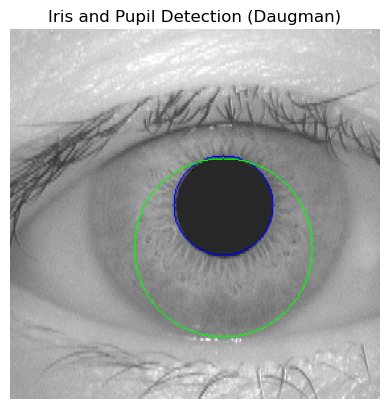

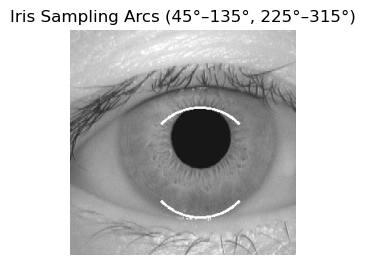

(161, 133) 38 (161, 165) 68


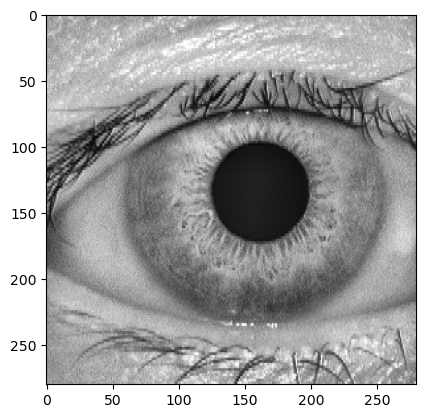

In [9]:
img_path = "eye.bmp"
pupil_center, pupil_r, iris_center, iris_r, image = segment_iris_and_pupil(img_path)
print(pupil_center, pupil_r, iris_center, iris_r)

In [3]:
def normalize_iris(image, pupil_center, pupil_radius, iris_center, iris_radius, n_theta=720, n_r=128):
    # Step 1: Generate theta and r
    theta = np.linspace(0, 2 * np.pi, n_theta)
    r = np.linspace(0, 1, n_r)
    
    # Step 2: Generate boundary coordinates
    xp = pupil_center[0] + pupil_radius * np.cos(theta)
    yp = pupil_center[1] + pupil_radius * np.sin(theta)
    
    xi = iris_center[0] + iris_radius * np.cos(theta)
    yi = iris_center[1] + iris_radius * np.sin(theta)
    
    # Step 3: Generate grid of sampling points
    theta_grid, r_grid = np.meshgrid(theta, r)
    
    xp_grid = xp[np.newaxis, :]
    yp_grid = yp[np.newaxis, :]
    xi_grid = xi[np.newaxis, :]
    yi_grid = yi[np.newaxis, :]
    
    x_norm = (1 - r_grid) * xp_grid + r_grid * xi_grid
    y_norm = (1 - r_grid) * yp_grid + r_grid * yi_grid
    
    # Step 4: Sample the image using map_coordinates
    coords = [y_norm.flatten(), x_norm.flatten()]  # Note: (row, col) = (y, x)
    normalized = map_coordinates(image, coords, order=1, mode='reflect')
    normalized = normalized.reshape((n_r, n_theta))
    
    return normalized

def show_normalized_iris(normalized_iris, image, pupil_center, pupil_r, iris_center, iris_r):
     # Display the original and normalized iris
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.scatter(*pupil_center, color='red', marker='x', label='Pupil Center')
    plt.scatter(*iris_center, color='blue', marker='x', label='Iris Center')
    circle1 = plt.Circle(pupil_center, pupil_r, color='red', fill=False)
    circle2 = plt.Circle(iris_center, iris_r, color='blue', fill=False)
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Normalized Iris')
    plt.imshow(normalized_iris, cmap='gray', aspect='auto')
    plt.xlabel('Theta (angle)')
    plt.ylabel('Radius (normalized)')
    plt.show()
    
def gabor_filter(kernel_size=51, sigma=4.0, theta=0, lambd=10.0, gamma=0.5, psi=0):
    """Generate a Gabor filter kernel."""
    y, x = np.meshgrid(np.arange(-kernel_size//2+1, kernel_size//2+1),
                       np.arange(-kernel_size//2+1, kernel_size//2+1))
    rotx = x * np.cos(theta) + y * np.sin(theta)
    roty = -x * np.sin(theta) + y * np.cos(theta)
    g = np.exp(-0.5 * (rotx**2 + (gamma**2) * roty**2) / sigma**2)
    g *= np.cos(2 * np.pi * rotx / lambd + psi)
    return g

def extract_iris_code(normalized_iris, gabor_kernel):
    filtered_real = convolve2d(normalized_iris, np.real(gabor_kernel), mode='same')
    filtered_imag = convolve2d(normalized_iris, np.imag(gabor_kernel), mode='same')
    iris_code = (filtered_real > 0).astype(np.uint8)  # Phase quantization to binary
    mask = (gaussian_filter(normalized_iris, sigma=2) < 10).astype(np.uint8)  # Mask dark (occluded) areas
    return iris_code, mask

def hamming_distance(code1, mask1, code2, mask2):
    valid_mask = np.logical_and(mask1, mask2)
    total_bits = np.sum(valid_mask)
    if total_bits == 0:
        return 1.0  # No valid bits to compare
    differences = np.logical_xor(code1, code2) & valid_mask
    hd = np.sum(differences) / total_bits
    return hd

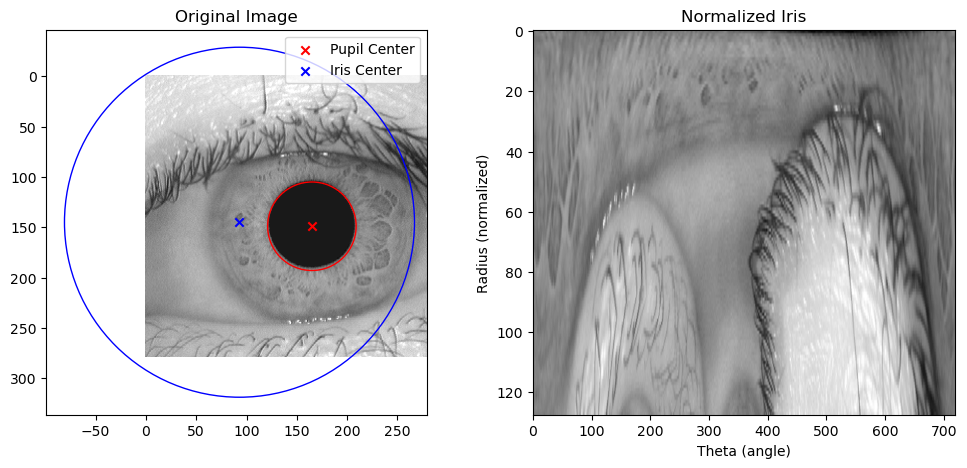

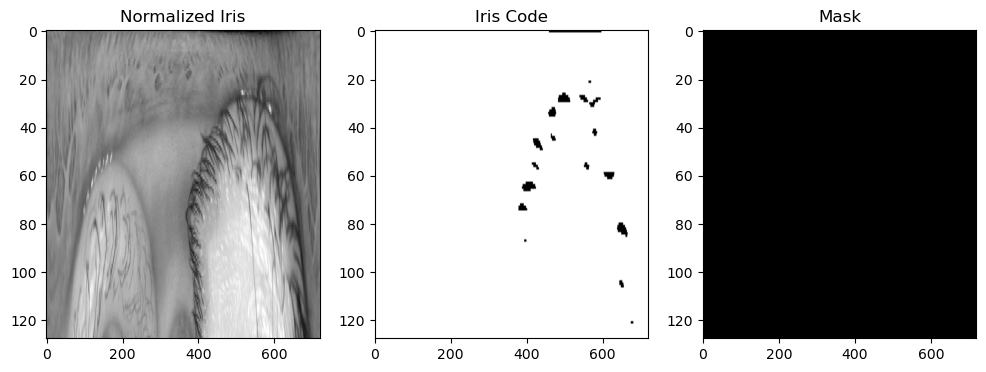

In [4]:
normalized_iris = normalize_iris(image, pupil_center, pupil_r, iris_center, iris_r)
show_normalized_iris(normalized_iris, image, pupil_center, pupil_r, iris_center, iris_r)
# Generate Gabor kernel
gabor_kernel = gabor_filter(kernel_size=31, sigma=4.0, theta=0, lambd=10.0, gamma=0.5, psi=0)

# Extract iris code and mask
iris_code, mask = extract_iris_code(normalized_iris, gabor_kernel)

# Visualize results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Normalized Iris')
plt.imshow(normalized_iris, cmap='gray', aspect='auto')

plt.subplot(1, 3, 2)
plt.title('Iris Code')
plt.imshow(iris_code, cmap='gray', aspect='auto')

plt.subplot(1, 3, 3)
plt.title('Mask')
plt.imshow(mask, cmap='gray', aspect='auto')
plt.show()


In [5]:
# Simulate matching with itself
hd = hamming_distance(iris_code, mask, iris_code, mask)
print(f"Hamming Distance (self-match): {hd:.4f}")

Hamming Distance (self-match): 1.0000
